# Server overload behaviour

## Overview

This document is attempting to show off that servers have a certain capacity level, and that operating beyond that capacity is unfixable, counter-productive, and bad for users.

This capacity level beyond which the server is thought to be in an overloaded state is variously called here a "coping point" or "breakdown point".

## Simulation

Let's build up a simpy-based simulation of server traffic. This is an adaptation of [https://simpy.readthedocs.io/en/latest/examples/carwash.html](https://simpy.readthedocs.io/en/latest/examples/carwash.html), and contains some angry python code, because my python is rudimentary.

Right off the bat, let's list some inaccuracies of this simulation:

* in real-world scenarios, increasing response times are coupled with clients - they decrease RPS due to clients backing off
* this doesn't take into account multitasking - server software has a tendency to process more requests in parallel than it has cores. This changes the result in short simulations, but the effect should average out over longer time periods.

I've used VSCode python plugin for authoring, and the following modules were installed separately:

    pip3 install numpy matplotlib simpy scipy

Let's start with base source the actual simulations will use.

In [2]:
import simpy
from pylab import *
%matplotlib inline

response_times = []
queue_sizes = []

class Result(object):
    def __init__(self, response_times, queue_sizes):
        self.response_times = response_times
        self.queue_sizes = queue_sizes

    def avg_resp_time(self):
        return np.average([rt[1] for rt in self.response_times])
    
    def max_resp_time(self):
        return np.max([rt[1] for rt in self.response_times])

    def max_queue_size(self):
        return np.max([qs[1] for qs in self.queue_sizes])
    
    def reqs_served(self):
        return len(self.response_times)

class Server(object):
    def __init__(self, env, available_cores, resp_time):
        self.env = env
        self.cores = simpy.Resource(env, available_cores)
        self.resp_time = resp_time

    def respond(self):
        yield self.env.timeout(self.resp_time)


def request(env, server):
    global response_times
    with server.cores.request() as request:
        start = env.now
        yield request
        yield env.process(server.respond())
        elapsed = env.now - start
        response_times.append((env.now, elapsed))

def handler(env, num_cores, resp_time, rps):
    global queue_sizes
    server = Server(env, num_cores, resp_time)
    interval = 1.0/rps
    while True:
        yield env.timeout(interval)
        env.process(request(env, server))
        queue_sizes.append((env.now, len(server.cores.queue)))

def simulate(num_cores, resp_time, rps, sim_time):
    global response_times, queue_sizes
    response_times = []
    queue_sizes = []

    env = simpy.Environment()
    env.process(handler(env, num_cores, resp_time, rps))
    env.run(until=sim_time)

    return Result(response_times, queue_sizes)


## Finding server breakdown point

In simulation, expressed in RPS, the breakdown point is obtained by dividing number of cores by average response time. For example with 1 core and 0.2 response times, we can expect to serve 5 requests per second. In reality, this is only partially true: theoretically, added concurency should alleviate some bottlenecks when processes are waiting for e.g. filesyste i/o. For example there is no reason not to process straightforward file requests while waiting for a DB query. This works up to a point: for example if you have a CPU-constrained application server uniform response times, theoretically fastest response times can be achieved by matching threads to actual cores.

For the calculations below I have used the following settings:

* available cores - 1
* average response time - 0.2s
* simulation time 60s

The first graph below illustrates different behaviours under and above the breakdown point. Under that point, increasing RPS linearly increases the amount of requests processed. There is also a permanent ceiling to how many requests the server can process, and, unsurprisingly, that ceiling is fixed. There is only so much CPU juice to go around after all.

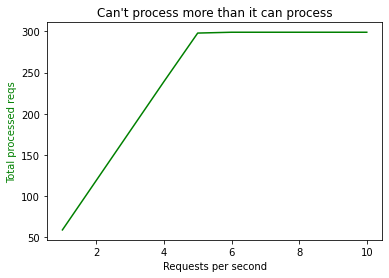

In [3]:
AvailableCores = 1
AvgRespTime = 0.2
SimTime = 60

rps = np.arange(1, 11, 1)
results = []
for i in range(len(rps)):
    results.append(simulate(AvailableCores, AvgRespTime, rps[i], SimTime))

fig, ax = plt.subplots()
ax.set_title("Can't process more than it can process")
ax.set_xlabel('Requests per second')
ax.set_ylabel('Total processed reqs', color='green')
ax.plot(rps, [r.reqs_served() for r in results], color='green')


Response times grow rapidly beyond the coping point. This affects all users indiscriminately, to the point where nobody can actually use the service.

The longer since the overload started, the higher the response times for everyone. After 60s, with server just beyond capacity (6 rps in this example), the max response times are already at 10s for what should have been a 0.2s request. After the same amount of time at 10 rps (twice the coping point), the wait for everyone is 30s.

This is why shedding load actually works - it's better for every 3rd person to receive a response (within human timescale), than nobody to receive it.

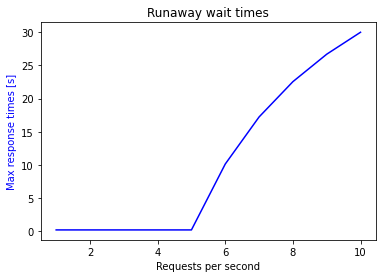

In [4]:
AvailableCores = 1
AvgRespTime = 0.2
SimTime = 60

rps = np.arange(1, 11, 1)
results = []
for i in range(len(rps)):
    results.append(simulate(AvailableCores, AvgRespTime, rps[i], SimTime))
    
fig, ax = plt.subplots()
ax.set_title("Runaway wait times")
ax.set_xlabel('Requests per second')
ax.set_ylabel('Max response times [s]', color='blue')
ax.plot(rps, [r.max_resp_time() for r in results], color='blue')

Note there is the quirk in the simulation. The slope of the increase is decreasing, but I think this is due to the response times getting longer than the simulation runtime, and the increase should probably be linear.

The more RPS, the more in-flight requests are present after the simulation finishes, and unfinished requests don't contribute to the response time statistic. The following graph shows the effect more clearly.

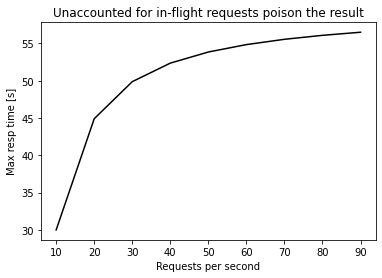

In [5]:
AvailableCores = 1
AvgRespTime = 0.2
SimTime = 60

rps = np.arange(10, 100, 10)
results = []
for i in range(len(rps)):
    results.append(simulate(AvailableCores, AvgRespTime, rps[i], SimTime))

fig, ax = plt.subplots()
ax.set_title("Unaccounted for in-flight requests poison the result")
ax.set_xlabel('Requests per second')
ax.set_ylabel('Max resp time [s]', color='black')
ax.plot(rps, [r.max_resp_time() for r in results], color='black')

But I digress.

The simulations also show the more time passed in overloaded state, the more response times grew, increasing linearly with time (see next plot).

In the real world (fortunately?) the server may be able to recover because people just give up if the response times are high, but they will come back again once the response times fall. This results in a wave pattern of ebb and flow of traffic, averaging the response times out to something humans can stomach. For services with motivated users who just won't back off (exam results, immigration quota application forms), there is really no recovery, and response times fly off to infinity.

Text(500, 260, '10 rps')

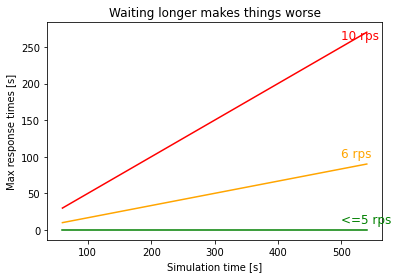

In [6]:
AvailableCores = 1
AvgRespTime = 0.2
Rps = 6

stime = np.arange(60, 600, 60)
results5 = []
results6 = []
results10 = []
for i in range(len(stime)):
    results5.append(simulate(AvailableCores, AvgRespTime, 5, stime[i]))
    results6.append(simulate(AvailableCores, AvgRespTime, 6, stime[i]))
    results10.append(simulate(AvailableCores, AvgRespTime, 10, stime[i]))

fig, ax = plt.subplots()
ax.set_title("Waiting longer makes things worse")
ax.set_xlabel('Simulation time [s]')
ax.set_ylabel('Max response times [s]')
ax.plot(stime, [r.max_resp_time() for r in results5], color='green')
ax.text(500, 10, "<=5 rps", fontsize=12, color="green")
ax.plot(stime, [r.max_resp_time() for r in results6], color='orange')
ax.text(500, 100, "6 rps", fontsize=12, color="orange")
ax.plot(stime, [r.max_resp_time() for r in results10], color='red')
ax.text(500, 260, "10 rps", fontsize=12, color="red")

The same linear dependency can be seen in the following alternative view. Queue growth is linear with time.

Text(500, 2900, '10 rps')

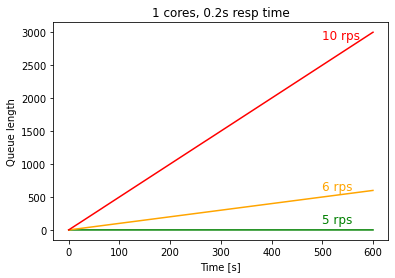

In [7]:
AvailableCores = 1
AvgRespTime = 0.2
SimTime = 600

fig, ax = plt.subplots()

ax.set_title("... and queue just keeps growing")
ax.set_xlabel('Time [s]')
ax.set_ylabel('Queue length')

result = simulate(AvailableCores, AvgRespTime, 5, SimTime)
ax.plot(*zip(*result.queue_sizes), color="green")
ax.text(500, 100, "5 rps", fontsize=12, color="green")

result = simulate(AvailableCores, AvgRespTime, 6, SimTime)
ax.plot(*zip(*result.queue_sizes), color="orange")
ax.text(500, 600, "6 rps", fontsize=12, color="orange")

result = simulate(AvailableCores, AvgRespTime, 10, SimTime)
ax.plot(*zip(*result.queue_sizes), color="red")
ax.text(500, 2900, "10 rps", fontsize=12, color="red")

## Conclusions

1. All the relationships involved in this simulation are linear, and the capacity calculation is fairly straightforward. Your intuition is probably correct
1. Servers have a breakdown point, beyond which it's only a matter of time for them to become inoperable. It's counter-productive to operate servers "at 100%", because it's probably masking an overload situation
1. The only fix for servers beyond breakdown point is to increase capacity (add cores, improve performance) or shed load (block longest-running pages, refuse n-th request, offload to caches)
1. Resetting the server (actually, zeroing the queue) is a temporary solution. Response times improve immediately but the queue starts growing right away. This is a valid strategy in two cases: to buy some time if the server is not too far beyond the coping point, and also to immediately "fix" the server if the underlying cause went away.